<a href="https://www.kaggle.com/code/averma111/pytorch-hubmap-cnn?scriptVersionId=131507328" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%capture 
!pip install torchmetrics

In [2]:
%%capture
!pip install torchsummary

In [54]:
import numpy as np
import pandas as pd
from glob import glob
import json
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AveragePrecision
from torchsummary import summary as torchsummary
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
class Config:
    batch_size= 128
    n_epochs = 50
    learning_rate = 0.001
    opt_func = torch.optim.Adam
    
    
    
config = Config()

In [14]:
class Acquisition:
    
    def get_datframe(self,path):
        return pd.read_csv(path)
    
    def get_json_dataframe(self, json_file):
        data = []
        with open(json_file, 'r') as file:
            for line in file:
                item = json.loads(line)
                data.append(item)
        
        json_df = pd.DataFrame(data)
        
        return json_df
    
    def get_image_path(self):
        train_image_path = glob(self.train)
        test_image_path = glob(self.test)
        return train_image_path,test_image_path
        
        
acq = Acquisition()      

In [15]:
title=acq.get_datframe(path='/kaggle/input/hubmap-hacking-the-human-vasculature/tile_meta.csv')
title.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [16]:
wsi = acq.get_datframe(path='/kaggle/input/hubmap-hacking-the-human-vasculature/wsi_meta.csv')
wsi.head()

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
polygons_df = acq.get_json_dataframe('/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl')
polygons_df.head()

,id,annotations
0,0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,..."
1,00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,..."
2,0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16..."
3,003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40..."
4,004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14..."


In [21]:
class ImageHuBMAPDataset(Dataset):
    
    def __init__(self, image_dir, labels_file, transform=None):
        
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]
            
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.json_labels)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
        image = Image.open(image_path)

        mask = np.zeros((512, 512), dtype=np.float32)

        for annot in self.json_labels[idx]['annotations']:
            cords = annot['coordinates']
            if annot['type'] == "blood_vessel":
                for cd in cords:
                    rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                    mask[rr, cc] = 1

        image = torch.tensor(np.array(image), dtype=torch.float32,requires_grad=True).permute(2, 0, 1)  
        mask = torch.tensor(mask, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, mask

In [48]:
image_folder = "/kaggle/input/hubmap-hacking-the-human-vasculature/train"
labels_file = "/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl"

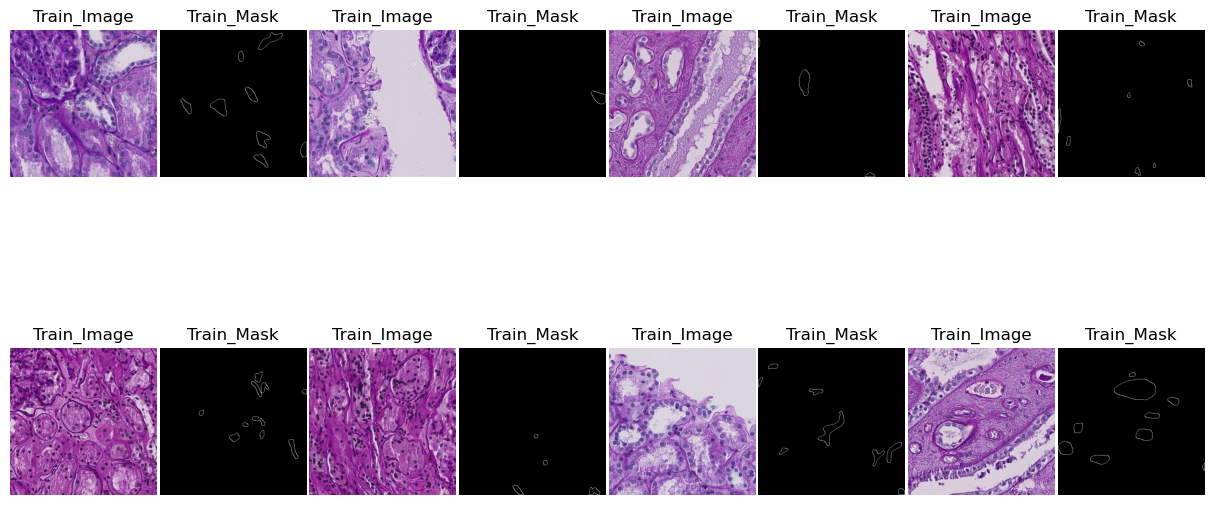

In [31]:
plt.figure(figsize=(12, 8))

dataset = ImageHuBMAPDataset(image_dir=image_folder, labels_file=labels_file)
num_samples = 8

num_rows = (num_samples + 3) // 4  # Each row contains 4 samples
num_cols = min(num_samples, 4)

for i in range(num_samples):

    image, mask = dataset[i]
    image = image.permute(1, 2, 0).detach().numpy() / 255
    subplot_index = i + 1

    plt.subplot(num_rows, 2 * num_cols, 2 * subplot_index - 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Train_Image')

    mask_subplot_index = (subplot_index - 1) % num_samples + 1

    plt.subplot(num_rows, 2 * num_cols, 2 * subplot_index)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Train_Mask')

plt.tight_layout(pad=0.2)
plt.show()

In [32]:
class HuBMAPClassificationBaseNN(torch.nn.Module):
    
    def training_step(self,batch):
        features,labels = batch
        out = self(features)
        loss = F.binary_cross_entropy(out,labels)
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        out = self(features)                   
        loss = F.binary_cross_entropy(out, labels)  
        acc = aurpc(out, labels)          
        return {'Validation_loss': loss.detach(), 'Validation_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['Validation_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'Validation_loss': epoch_loss.item(), 'Validation_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        if epoch%5==0:
            print("Epoch [{}], Train_loss: {:.4f}, Validation_loss: {:.4f}, Validation_acc: {:.4f}".format(
            epoch, result['Train_loss'], result['Validation_loss'], result['Validation_acc']))

In [44]:
class HuBMAPClassificationNN(HuBMAPClassificationBaseNN):
    def __init__(self):
        super(HuBMAPClassificationNN, self).__init__()
        
        self.network_1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.network_2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 1, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.network_1(x)
        x = self.network_2(x)
        x = torch.sigmoid(x)
        return x

In [45]:
model = HuBMAPClassificationNN().to(device)

In [55]:
def train_test_dataset(features,labels):
    return  train_test_split(features,labels,shuffle=True,random_state=42)

In [56]:
X_train,X_val,y_train,y_val = train_test_dataset(image_folder,labels_file)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

ValueError: Found input variables with inconsistent numbers of samples: [56, 65]

In [47]:

dataset = ImageHuBMAPDataset(image_dir=image_folder, labels_file=labels_file)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [46]:
#torchsummary(model, X_data.size(), batch_size=-1, device='cuda')

NameError: name 'X_data' is not defined

In [ ]:
class Trainer:
    
    def aurpc(outputs, labels):
        aurpc = AveragePrecision(task="binary")
        return aurpc(outputs, labels)

  
    @torch.no_grad()
    def evaluate(model, val_loader):
        model.eval()
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

  
    def fit(epochs, lr, model, train_loader, val_loader, opt_func = OPT_FUNC):
    
        history = []
        optimizer = opt_func(model.parameters(),lr)
        for epoch in tqdm(range(epochs)):
        
            model.train()
            train_losses = []
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            result = evaluate(model, val_loader)
            result['Train_loss'] = torch.stack(train_losses).mean().item()
            model.epoch_end(epoch, result)
            history.append(result)
    
        return history
    
    
trainer = Trainer()

In [ ]:
history = trainer.fit(config.n_epochsn, config.learning_rate, model, train_dl, val_dl, config.opt_func)

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['Validation_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('Train_loss') for x in history]
    val_losses = [x['Validation_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)